# A simple demo of AdaSTEM model using stemflow package

Yangkang Chen<br>
Sep 12, 2023

In [1]:

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os
import h3pandas

# warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Download data

Please download the sample data from:<br>
https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745<br>
Suppose now it's downloaded and saved as './Sample_data_Mallard.csv'<br>

you can also try other species like <br>
https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751<br>
https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742<br>
https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748<br>


In [4]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)


## Get X and y

In [5]:
X = data.drop('count', axis=1)
y = data['count'].values


## First thing first: Spatio-temporal train test split

In [6]:
from stemflow.model_selection import ST_train_test_split
X_train, X_test, y_train, y_test = ST_train_test_split(X, y, 
                                                       Spatio_blocks_count = 50, Temporal_blocks_count=50,
                                                       random_state=42, test_size=0.3)


## Train AdaSTEM hurdle model

In [7]:
from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor # remember to install xgboost if you use it as base model
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle


In [8]:
model = AdaSTEMRegressor(
    base_model=Hurdle(
        classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
        regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
    ),
    save_gridding_plot = True,
    ensemble_fold=10, 
    min_ensemble_required=7,
    grid_len_lon_upper_threshold=25,
    grid_len_lon_lower_threshold=5,
    grid_len_lat_upper_threshold=25,
    grid_len_lat_lower_threshold=5,
    points_lower_threshold=50,
    Spatio1='longitude',
    Spatio2 = 'latitude', 
    Temporal1 = 'DOY',
    use_temporal_to_train=True,
    njobs=4                       
)



In [9]:
# columns of X_train should only contain predictors and Spatio-temporal indicators (Spatio1, Spatio2, Temporal1)
model.fit(X_train.reset_index(drop=True), y_train)


100%|██████████| 42336/42336 [07:51<00:00, 89.80it/s]  


## Feature importances

In [15]:
# Calcualte feature importance.
model.calculate_feature_importances()
# stixel-specific feature importance is saved in model.classifier.feature_importances_

In [16]:
# Assign the feature importance to spatio-temporal points of interest
importances_by_points = model.assign_feature_importances_by_points(verbosity=1, njobs=4)


100%|██████████| 10/10 [10:30<00:00, 63.03s/it]


In [17]:
importances_by_points.head()

,DOY,longitude,latitude,DOY_predictor,duration_minutes,Traveling,Stationary,effort_distance_km,number_observers,obsvr_species_count,time_observation_started_minute_of_day,elevation_mean,slope_mean,eastness_mean,northness_mean,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19,croplands,evergreen_broadleaf_forests,grasslands,permanent_wetlands,savannas,urban_and_built_up_lands,water_bodies,woody_savannas,entropy,closed_shrublands,non_vegetated_lands,open_shrublands,cropland_or_natural_vegetation_mosaics,deciduous_broadleaf_forests,evergreen_needleleaf_forests,mixed_forests,Area,deciduous_needleleaf_forests
800673,15,167,-49,0.118861,0.022662,0.000357,0.000433,0.021662,0.031269,0.015218,0.015602,0.075139,0.026430,0.017258,0.041881,0.189449,0.031809,0.068475,0.035672,0.031313,0.029774,0.028046,0.013167,0.009545,0.003951,0.001789,0.021175,0.011150,0.012526,0.00610,0.001544,0.006735,0.022759,0.002435,0.0,0.000000,0.009681,0.002878,0.013978,0.0,0.007599,0.006706,0.032455,0.0,0.00165,0.0,0.0,0.0,0.005485,0.005381,8.763975e-08,0.0
800674,22,167,-49,0.120386,0.023060,0.000357,0.000433,0.022603,0.025964,0.016357,0.016213,0.075996,0.021691,0.019056,0.040663,0.165719,0.027716,0.068853,0.035672,0.022137,0.029774,0.028046,0.014470,0.009545,0.008265,0.001789,0.021175,0.048954,0.012825,0.00610,0.001143,0.006735,0.022097,0.003575,0.0,0.000000,0.010331,0.002878,0.013496,0.0,0.007599,0.003353,0.032455,0.0,0.00165,0.0,0.0,0.0,0.005485,0.005381,8.763975e-08,0.0
800777,1,169,-49,0.162956,0.026113,0.001546,0.000190,0.040963,0.015238,0.013055,0.039707,0.063454,0.024842,0.018478,0.034550,0.137070,0.031974,0.062177,0.050130,0.030544,0.024965,0.021869,0.008772,0.013669,0.009168,0.000200,0.026513,0.013978,0.014453,0.00411,0.001944,0.006773,0.020717,0.003793,0.0,0.003756,0.007184,0.003806,0.013407,0.0,0.006900,0.006706,0.029670,0.0,0.00000,0.0,0.0,0.0,0.002333,0.002330,8.763975e-08,0.0
800778,8,169,-49,0.139282,0.026656,0.001545,0.000190,0.041318,0.029572,0.012819,0.038971,0.064775,0.025567,0.018224,0.032396,0.143658,0.030302,0.062661,0.047465,0.030679,0.030590,0.014728,0.012174,0.013669,0.009811,0.000200,0.025708,0.014123,0.014453,0.00411,0.001773,0.007005,0.021025,0.003793,0.0,0.003756,0.009575,0.003806,0.012877,0.0,0.006920,0.006706,0.030733,0.0,0.00000,0.0,0.0,0.0,0.003146,0.003243,8.763975e-08,0.0
800779,15,169,-49,0.130961,0.026377,0.000021,0.000190,0.041694,0.030485,0.013782,0.039695,0.063383,0.025861,0.017241,0.037254,0.153068,0.033924,0.059375,0.040272,0.032220,0.030458,0.019645,0.011912,0.012569,0.008420,0.000200,0.026693,0.014123,0.014453,0.00411,0.001967,0.006952,0.021126,0.003683,0.0,0.002765,0.008959,0.003806,0.012714,0.0,0.007210,0.006706,0.031004,0.0,0.00000,0.0,0.0,0.0,0.001410,0.003311,8.763975e-08,0.0


In [18]:
# top 10 important variables
top_10_important_vars = importances_by_points[[
    i for i in importances_by_points.columns if not i in ['DOY','longitude','latitude','longitude_new','latitude_new']
    ]].mean().sort_values(ascending=False).head(10)

print(top_10_important_vars)


DOY_predictor                             0.055412
duration_minutes                          0.047532
effort_distance_km                        0.040931
slope_mean                                0.039142
elevation_mean                            0.038503
obsvr_species_count                       0.036831
eastness_mean                             0.035802
bio1                                      0.034254
time_observation_started_minute_of_day    0.033317
northness_mean                            0.030895
dtype: float64


## Ploting the feature importances by vairable names

In [19]:
from stemflow.utils.plot_gif import make_sample_gif

# make spatio-temporal GIF for top 3 variables
for var_ in top_10_important_vars.index[:3]:
    make_sample_gif(importances_by_points, f'./FTR_IPT_{var_}.gif',
                                col=var_, log_scale = False,
                                Spatio1='longitude', Spatio2='latitude', Temporal1='DOY',
                                figsize=(18,9), xlims=(-180, 180), ylims=(-90,90), grid=True,
                                xtick_interval=20, ytick_interval=20,
                                lng_size = 360, lat_size = 180, dpi=100, fps=10)


0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!
0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!
0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!


![GIF of feature importance for vairable `slope_mean`](../FTR_IPT_slope_mean.gif)

## Plot uncertainty (error) in training 

In [21]:
# calculate mean and standard deviation in occurence estiamtion (classifier)
pred_mean, pred_std = model.predict(X_train.reset_index(drop=True), 
                                               return_std=True, verbosity=0, njobs=1)



In [22]:
# Aggregate error to hexagon
error_df = X_train[['longitude', 'latitude']]
error_df.columns = ['lng', 'lat']
error_df['pred_std'] = pred_std

H_level = 3
error_df = error_df.h3.geo_to_h3(H_level)
error_df = error_df.reset_index(drop=False).groupby(f'h3_0{H_level}').mean()
error_df = error_df.h3.h3_to_geo_boundary()



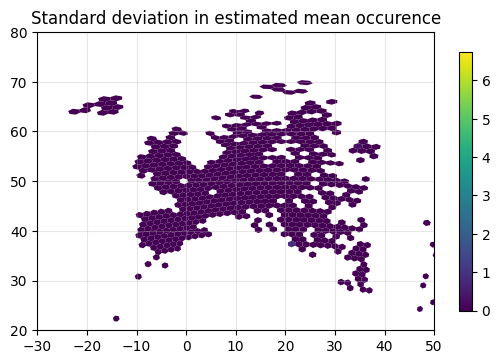

In [23]:
# plot mean error in hexagon
error_df.plot('pred_std', legend=True, legend_kwds={'shrink':0.7})
plt.grid(alpha=0.3)

plt.xlim(-30, 50)
plt.ylim(20, 80)
plt.title('Standard deviation in estimated mean abundance')
plt.show()

## Save model

In [18]:
with open('./01.demo_adastem_model.pkl','wb') as f:
    pickle.dump(model, f)
    

## Evaluation

In [25]:
pred = model.predict(X_test)


In [26]:
perc = np.sum(np.isnan(pred.flatten()))/len(pred.flatten())
print(f'Percentage not predictable {round(perc*100, 2)}%')

Percentage not predictable 4.02%


In [27]:
pred_df = pd.DataFrame({
    'y_true':y_test.flatten(),
    'y_pred':np.where(pred.flatten()<0, 0, pred.flatten())
}).dropna()


In [28]:
AdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred)


{'AUC': 0.7695136774858878,
 'kappa': 0.3812941787230687,
 'f1': 0.521482361574616,
 'precision': 0.3886602771121992,
 'recall': 0.7922174443913574,
 'average_precision': 0.3429921144433864,
 'Spearman_r': 0.474203436539852,
 'Pearson_r': 0.20350819285750119,
 'R2': -0.03508536794560557,
 'MAE': 4.226478620156369,
 'MSE': 1321.8448138157983,
 'poisson_deviance_explained': 0.13412571198761414}

## Compared to simple Hurdle model

In [29]:
model2 = Hurdle(classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1))
model2.fit(X_train[[i for i in X_train.columns if not i in ['longitude','latitude']]], y_train)
pred2 = model2.predict(X_test[[i for i in X_train.columns if not i in ['longitude','latitude']]])

AdaSTEM.eval_STEM_res('hurdle', y_test.flatten(), np.where(pred2.flatten()<0, 0, pred2.flatten()))

{'AUC': 0.614874754867373,
 'kappa': 0.3024531192247014,
 'f1': 0.3682267387656163,
 'precision': 0.643005991143527,
 'recall': 0.25798191984114544,
 'average_precision': 0.288061783500689,
 'Spearman_r': 0.3520394407206567,
 'Pearson_r': 0.15540117044791554,
 'R2': -0.11859108757092018,
 'MAE': 3.99918310458487,
 'MSE': 1405.505184365956,
 'poisson_deviance_explained': 0.06904965429918242}

## Plot QuadTree ensembles

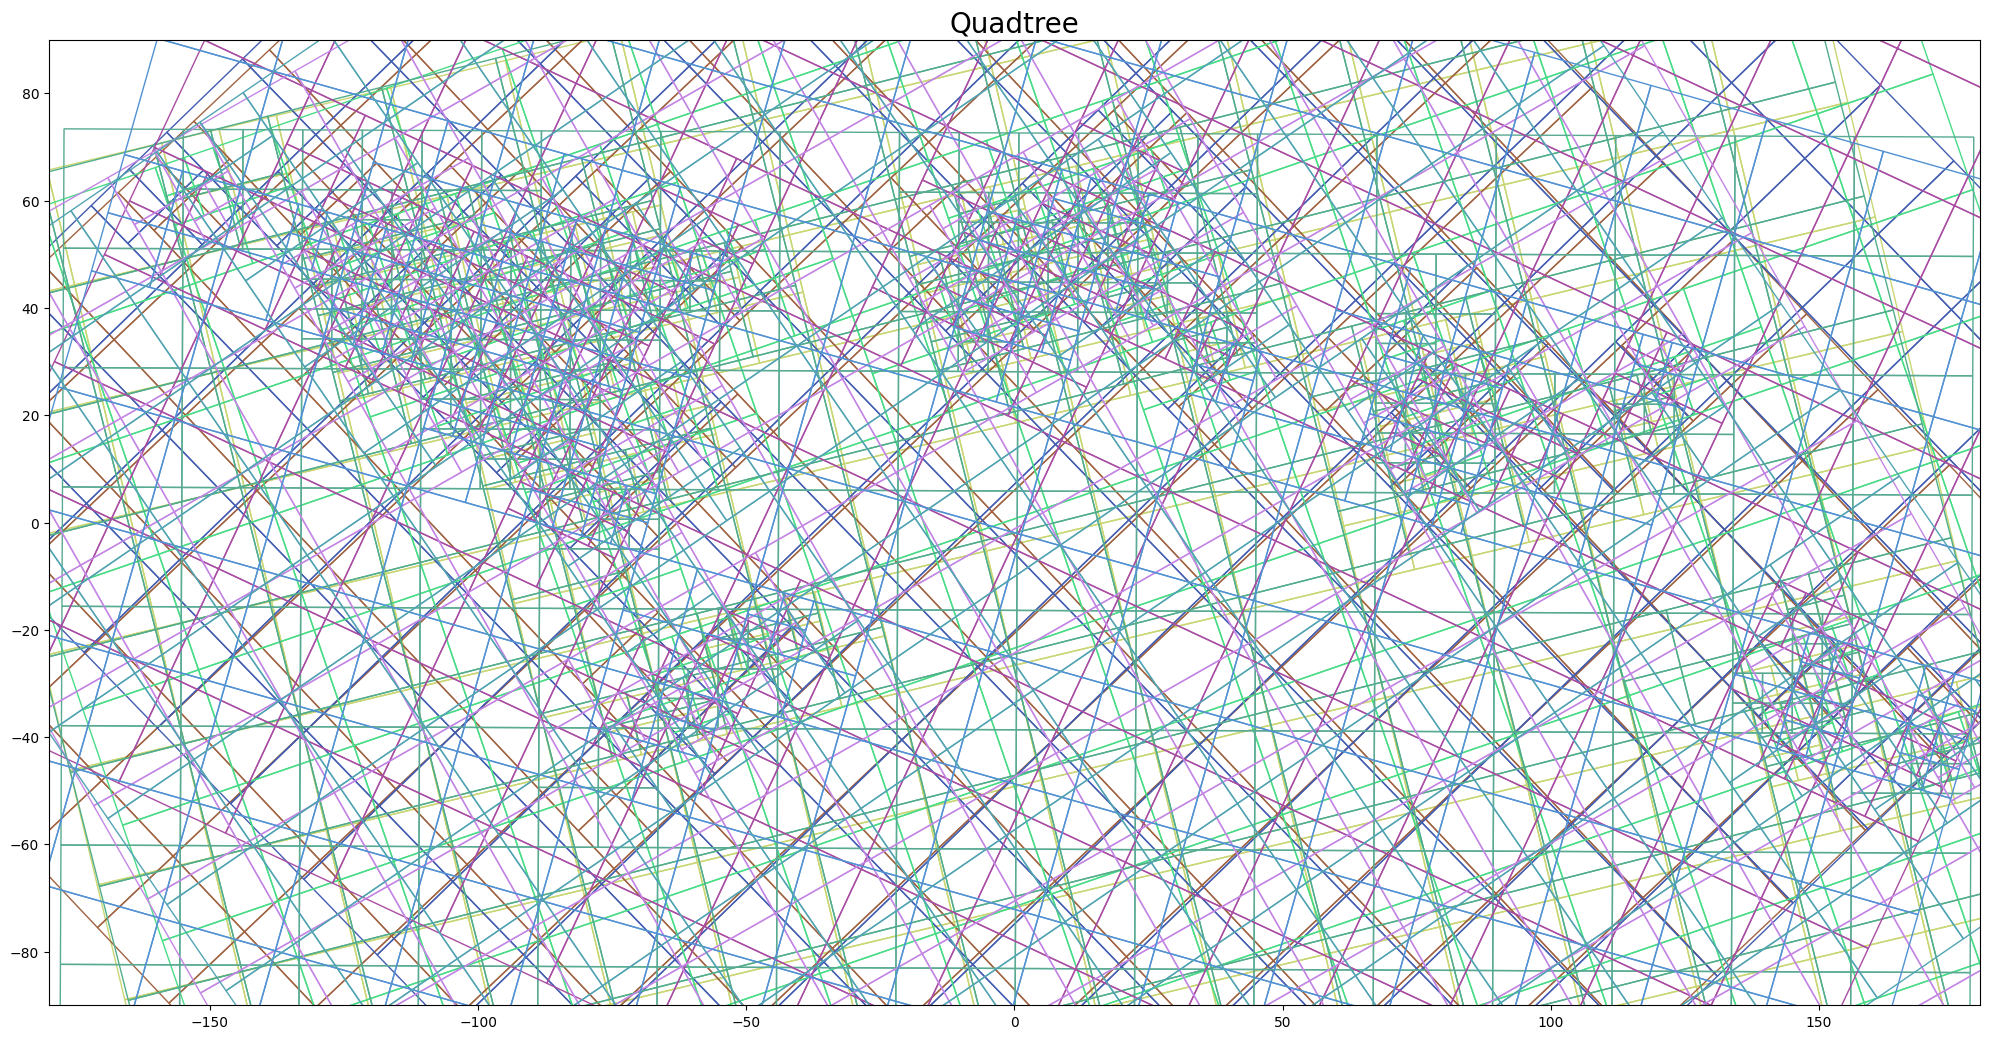

In [32]:
model.gridding_plot

In [33]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,scikit-learn"))


Last updated: 2023-09-19T10:28:02.659934+08:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.14.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

stemflow    : 0.0.24
numpy       : 1.24.3
scipy       : 1.10.1
pandas      : 2.0.3
xgboost     : 1.7.6
tqdm        : 4.65.0
matplotlib  : 3.7.1
h3pandas    : 0.2.4
geopandas   : 0.11.1
scikit-learn: 0.0

